Now analysis of parsed data from part 1.

Useful ref http://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

http://stackoverflow.com/questions/21828398/what-is-the-difference-between-pandas-agg-and-apply-function

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext watermark
%watermark -a 'Robin_Cole' -u -d -v -p numpy,pandas,matplotlib

Robin_Cole 
last updated: 2016-09-30 

CPython 3.5.2
IPython 4.2.0

numpy 1.11.1
pandas 0.18.1
matplotlib 1.5.1


In [3]:
pwd

'/Users/robincole/Dropbox/00 MSc project data backup/30-9-2016'

## Helper functions

In [4]:
def query_data(Col, structure, metric):   # helper function to get data, Col = AAA, AXB or diff
    temp = d[Col][(d['structure'] == structure) & (d['metric'] == metric)]
    return temp

In [5]:
def diff_percent(a,ref):
    return 100*((a-ref)/ref)

print(diff_percent(25.0,100.0))

-75.0


In [97]:
def my_wilcox(data):                    # helper function to return p-value, pass difference data as series from dataframe
    z_stat, p_val = wilcoxon(data)   # if only 1 value passed
    #z_stat, p_val = wilcoxon(data.as_matrix())   # if only 1 value passed
    return p_val

In [98]:
my_wilcox([1,2,3,4,6,7,2,352,3])

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


0.0075792819433897285

In [84]:
def bland_altman_plot(data1, data2, structure, metric, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    z_stat, p_val = wilcoxon(data1, data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='red', linestyle='-')
    plt.axhline(md + 1.96*sd, color='blue', linestyle='--')
    plt.axhline(md - 1.96*sd, color='blue', linestyle='--')
    plt.xlabel('Dose (Gy)')
    plt.ylabel('Difference (Gy)')
    plt.title( str(np.round(md, decimals = 3)) + ' Gy differnece with p = ' + str(np.round(p_val, decimals = 3))  + ' for ' + structure + ' and metric ' + metric)
    plt.savefig('BA.png')

## Import and clean data 

In [22]:
d = pd.read_csv('AAA_Dm_data_30_9.csv')

Drop entries with no values, and calculate percent difference

In [23]:
d = d[d.AAA != 0]    # drop zero rows

In [24]:
#d = d[d.structure != 'L Brachial plex']   # drop these
#d = d[d.structure != 'Both Lungs']
#d = d[d.metric != 'V20GY']
#d = d[d.metric != 'V30GY']
#d = d[d.metric != 'V40GY']
#d = d[d.metric != 'V50GY']
#d = d[d.metric != 'V55GY']
#d = d[d.metric != 'DRX']

In [25]:
# d['diff'] = diff_percent(d.Dm, d.AAA)  # create % difference col

In [26]:
d['diff'] = d.Dm - d.AAA  # create absolute difference col, not %

In [27]:
d.head()

,Case,structure,metric,AAA,Dm,diff
0,Case1,BODY,D2%,25.853042,25.685894,-0.167149
1,Case1,BODY,D5%,14.523130,14.388797,-0.134333
2,Case1,BODY,D50%,0.430243,0.399853,-0.030390
3,Case1,BODY,D95%,0.047550,0.065952,0.018402
4,Case1,BODY,D99%,0.009510,0.022860,0.013350


In [28]:
d.describe()

,AAA,Dm,diff
count,4397.000000,4397.000000,4397.000000
mean,25.492428,25.631111,0.138683
std,46.785916,40.686642,33.675847
min,0.000026,0.000000,-1737.625859
25%,0.806045,0.840868,-0.080013
50%,8.585360,8.778476,0.000000
75%,49.698004,52.643327,0.055000
max,1741.519369,781.014497,736.296230


In [29]:
d.loc[d['diff'].idxmax()] # Some large differences for Brachial plex, INVESTIGATE

Case                  Case31
structure    R Brachial plex
metric                   DHI
AAA                  44.7183
Dm                   781.014
diff                 736.296
Name: 4978, dtype: object

In [31]:
d[d['diff']>20]   # see the extreme cases

,Case,structure,metric,AAA,Dm,diff
216,Case1,R Brachial plex,D2%,0.326193,67.208837,66.882643
217,Case1,R Brachial plex,D5%,0.320481,60.524591,60.204110
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636
226,Case1,R Brachial plex,DHI,0.592426,326.333232,325.740806
437,Case5,Heart,D1CC,0.164974,55.756089,55.591115
514,Case5,Lt_Lung,DHI,149.879770,268.949980,119.070210
604,Case5,Both Lungs-ITV,DHI,114.399748,145.013911,30.614163
802,Case11,L Brachial plex,DHI,693.089728,730.475567,37.385840
1116,Case12,L Brachial plex,D2%,0.107434,73.246165,73.138730
1117,Case12,L Brachial plex,D5%,0.103586,70.172911,70.069326


In [32]:
#d = d[d['diff']<100.0] # drop extreme cases where difference is greater than 100%

In [64]:
d.metric.unique()

array(['D2%', 'D5%', 'D50%', 'D95%', 'D99%', 'D1CC', 'D0.1CC', 'DMAX',
       'DSD', 'DRX', 'DHI', 'V5GY', 'V12.5GY', 'V20GY', 'V30GY', 'V40GY',
       'V50GY', 'V55GY'], dtype=object)

In [147]:
d.structure.unique()

array(['BODY', 'GTV', 'Heart', 'Foramen', 'Foramen+3mm', 'Oesophagus',
       'Trachea', 'Bronchial tree', 'L Brachial plex', 'R Brachial plex',
       'Airway avoidance', 'PTV CHEST', 'Lt_Lung', 'PTV ring 2-3cm',
       'Rt_Lung', 'Both Lungs-ITV', 'Skin', 'Ribs', 'Skin-PTV+2cm', 'ITV',
       'Ribs-PTV', 'Inner Ring', 'Body', 'Both Lungs', 'Great vessels',
       'Liver'], dtype=object)

In [128]:
d.Case.unique()
print(d.Case.unique().size)

15


# Check against constraints

In [436]:
constraints = pd.read_csv('SABR_lung_constraints.csv')
constraints = constraints.drop('3_Fraction_54Gy', 1)   # drop 54 Gy

In [472]:
# constraints[(constraints['Structure'] == 'PTV CHEST') & (constraints['Metric'] == 'D95%')]
constraints = constraints[constraints['metric'].isin(d.metric.unique())]   # get only constraints where we have exported metrics
constraints

,structure,metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?
0,PTV CHEST,D95%,>,100,%,1
1,PTV CHEST,D99%,>,90,%,1
2,PTV CHEST,D0.1CC,between,118-134,%,1
3,Foramen,DMAX,<,25,Gy,0
4,Oesophagus,D0.1CC,<,27,Gy,0
5,R Brachial plex,D0.1CC,<,27,Gy,0
6,L Brachial plex,D0.1CC,<,27,Gy,0
7,Heart,D0.1CC,<,27,Gy,0
8,Trachea,D0.1CC,<,32,Gy,0
9,Bronchial tree,D0.1CC,<,32,Gy,0


In [438]:
PTV_D95_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D95%') & (d['AAA'] > 55.0) & (d['Dm'] < 55.0)]
#print(wilcoxon(test_df['diff'])) 
PTV_D95_fail

,Case,structure,metric,AAA,Dm,diff
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539


In [439]:
PTV_D99_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D99%') & (d['AAA'] > 0.9*55.0) & (d['Dm'] < 0.9*55.0)]
PTV_D99_fail  

,Case,structure,metric,AAA,Dm,diff


In [440]:
PTV_D01CC_fail = d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D0.1CC') & (((d['AAA'] > 1.18*55) & (d['Dm'] < 1.18*55)) | ((d['AAA'] < 1.34*55) & (d['Dm'] > 1.34*55)))]
print(1.18*55)
print(1.34*55)
PTV_D01CC_fail

64.89999999999999
73.7


,Case,structure,metric,AAA,Dm,diff
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344


In [441]:
Foramen_D01CC_fail = d[(d['structure'] == 'Foramen') & (d['metric'] == 'DMAX') & (d['AAA'] < 25.0) & (d['Dm'] > 25.0)]
Foramen_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff


In [442]:
Oesophagus_D01CC_fail = d[(d['structure'] == 'Oesophagus') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
Oesophagus_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff


In [443]:
LBrachial_D01CC_fail = d[(d['structure'] == 'L Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
LBrachial_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802


In [444]:
RBrachial_D01CC_fail = d[(d['structure'] == 'R Brachial plex') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 27.0) & (d['Dm'] > 27.0)]
RBrachial_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636
2814,Case17,R Brachial plex,D0.1CC,0.435957,48.809596,48.373640


In [445]:
Heart_D01CC_fail = d[(d['structure'] == 'Heart') & (d['metric'] == 'D0.1CC')& (d['Dm'] > 27.0) & (d['AAA'] < 27.0)]
Heart_D01CC_fail 

,Case,structure,metric,AAA,Dm,diff


In [446]:
Trachea_D01CC_fail = d[(d['structure'] == 'Trachea') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Trachea_D01CC_fail  

,Case,structure,metric,AAA,Dm,diff
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465


In [447]:
Bronchial_D01CC_fail = d[(d['structure'] == 'Bronchial tree') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 32.0) & (d['Dm'] > 32.0)]
Bronchial_D01CC_fail 

,Case,structure,metric,AAA,Dm,diff


In [448]:
Ribs_D01CC_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'D0.1CC') & (d['AAA'] < 35.0) & (d['Dm'] > 35.0)]
Ribs_D01CC_fail 

,Case,structure,metric,AAA,Dm,diff


In [449]:
Ribs_V30_fail = d[(d['structure'] == 'Ribs') & (d['metric'] == 'V30GY') & (d['AAA'] < 30.0) & (d['Dm'] > 30.0)]
Ribs_V30_fail 

,Case,structure,metric,AAA,Dm,diff


In [450]:
Lungs_V20_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V20GY') & (d['AAA'] < 10.0) & (d['Dm'] > 10.0)]
Lungs_V20_fail 

,Case,structure,metric,AAA,Dm,diff


In [451]:
Lungs_V125_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V12.5GY') & (d['AAA'] < 15.0) & (d['Dm'] > 15.0)]
Lungs_V125_fail 

,Case,structure,metric,AAA,Dm,diff


In [452]:
Lungs_V5_fail = d[(d['structure'] == 'Both Lungs-ITV') & (d['metric'] == 'V5GY') & (d['AAA'] < 26.0) & (d['Dm'] > 26.0)]
Lungs_V5_fail 

,Case,structure,metric,AAA,Dm,diff


In [453]:
Liver_D50_fail = d[(d['structure'] == 'Liver') & (d['metric'] == 'D50%') ]
Liver_D50_fail   

,Case,structure,metric,AAA,Dm,diff
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825


Need to export Lungs-ITV D1500CC, D1000CC, Liver 700CC, V21, V15, DMEAN

Investigate these failures.

In [454]:
failures = PTV_D95_fail
failures = failures.append(PTV_D01CC_fail)
failures = failures.append(Trachea_D01CC_fail)
failures = failures.append(Liver_D50_fail)
failures = failures.append(LBrachial_D01CC_fail)
failures = failures.append(RBrachial_D01CC_fail)

print(failures.Case.unique().size)
failures

8


,Case,structure,metric,AAA,Dm,diff
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636


# How do the metrics compare for PTV? Extract difference (%) by metric for PTV

In [130]:
d_PTV =  d[d['structure']  == 'PTV CHEST'].groupby(['metric'])
d_PTV = d_PTV.diff.mean()  # get mean diff values
# d_PTV.sort_values(ascending=False) #d_PTV.groups.keys()

In [131]:
# d_PTV.sort_values(ascending=False).plot(kind='bar', figsize=(8,6))

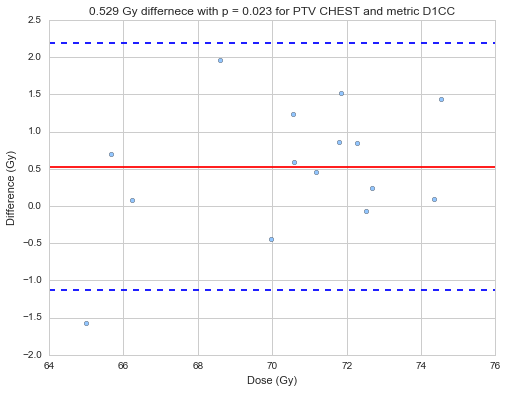

In [85]:
fig = plt.figure(figsize=(8, 6))
structure = 'PTV CHEST'
metric = 'D1CC'
bland_altman_plot(query_data('Dm', structure, metric), query_data('AAA',structure, metric), structure, metric)
plt.show()

Histograms of data PTV data

/Users/robincole/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


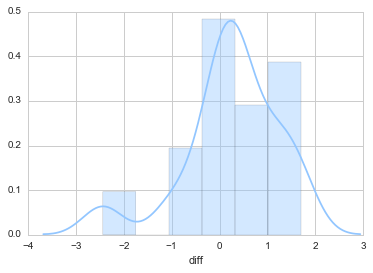

In [86]:
#ax2 = sns.distplot(query_data('diff', 'PTV CHEST', 'D50%'))   # quick test

fig = plt.figure(figsize=(6, 4))
data=query_data('diff', 'PTV CHEST', 'D50%')

# plt.subplot(1, 2, 1)
ax2 = sns.distplot(data)

#plt.subplot(1, 2, 2)
#ax = sns.violinplot(data)  

In [122]:
data=query_data('diff', 'PTV CHEST', 'D50%')
# ax = sns.violinplot(data)  

# Extract stats grouped by structure for D50% metric

In [222]:
stats = {  'Mean' : 'mean', 'Variance':'var', 'SEM':'sem', 'Counts':'count', 'Max':'max'} 

aggregations = {'diff': stats, 'AAA': stats, 'Dm': stats}  # 

res_table = d[d['metric']  == 'D50%'].groupby(['structure']).agg(aggregations)   # returns a heirachial dataframe
res_table

diff                                               AAA  \
                        Max      Mean       SEM Counts    Variance        Max   
structure                                                                       
Airway avoidance   0.053335 -0.018405  0.009802     14    0.001345   4.294166   
BODY               0.011675 -0.003599  0.004211     14    0.000248   0.795144   
Body               0.001679  0.001679       NaN      1         NaN   0.195553   
Both Lungs         0.014224 -0.008474  0.013606      5    0.000926   0.843066   
Both Lungs-ITV     0.032892 -0.018235  0.010556     15    0.001672   1.988173   
Bronchial tree     0.128285  0.007682  0.016811     15    0.004239   8.439325   
Foramen            0.025543 -0.071230  0.020161     15    0.006097   5.667792   
Foramen+3mm        0.024562 -0.071668  0.022756     18    0.009321   4.790450   
GTV               -0.900259 -0.900259       NaN      1         NaN  68.431595   
Great vessels     -0.049074 -0.049074       NaN      1         NaN   5.791010   
Heart              0.050727 -0.006242  0.009650     15    0.001397   4.147895   
ITV                1.828439  0.568196  0.195352     14    0.534273  72.625746   
Inner Ring         0.567988  0.283500  0.090871      6    0.049546  21.765047   
L Brachial plex   39.023162  4.801599  3.137878     14  137.847887  21.577226   
Liver              0.044248 -0.045289  0.089537      2    0.016034   6.847959   
Lt_Lung            0.012416 -0.036095  0.008498     15    0.001083   4.591914   
Oesophagus         0.032761 -0.025135  0.023482     15    0.008271  10.879130   
PTV CHEST          1.697743  0.235042  0.265863     15    1.060251  67.930126   
PTV ring 2-3cm     0.763267  0.201877  0.086762     15    0.112914  15.764528   
R Brachial plex   18.718139  1.258501  1.247171     15   23.331538   5.845632   
Ribs               0.181102 -0.058496  0.027261     15    0.011147   9.600965   
Ribs-PTV           0.015631 -0.040976  0.015306     13    0.003046   9.466300   
Rt_Lung            0.006038 -0.029733  0.010315     15    0.001596   4.139474   
Skin              -0.002897 -0.025002  0.004431     14    0.000275   0.379267   
Skin-PTV+2cm       0.019201 -0.001662  0.006728      6    0.000272   0.248402   
Trachea            0.067776 -0.000304  0.007223     15    0.000783   7.594444   

                                                                Dm             \
                       Mean       SEM Counts   Variance        Max       Mean   
structure                                                                       
Airway avoidance   1.661559  0.365226     14   1.867464   4.298916   1.643154   
BODY               0.246105  0.052294     14   0.038285   0.773711   0.242507   
Body               0.195553       NaN      1        NaN   0.197232   0.197232   
Both Lungs         0.556355  0.077298      5   0.029875   0.853047   0.547881   
Both Lungs-ITV     0.792836  0.134915     15   0.273032   2.021065   0.774601   
Bronchial tree     2.945618  0.671913     15   6.772002   8.483425   2.953300   
Foramen            1.392521  0.428487     15   2.754010   5.487468   1.321290   
Foramen+3mm        1.240382  0.289303     18   1.506528   4.546625   1.168714   
GTV               68.431595       NaN      1        NaN  67.531335  67.531335   
Great vessels      5.791010       NaN      1        NaN   5.741936   5.741936   
Heart              1.168729  0.349251     15   1.829647   4.101507   1.162487   
ITV               69.349294  0.451874     14   2.858661  74.081748  69.917490   
Inner Ring        17.985849  1.329992      6  10.613276  21.954055  18.269349   
L Brachial plex    3.273389  2.023029     14  57.297075  39.105000   8.074987   
Liver              4.049296  2.798663      2  15.665031   6.713133   4.004007   
Lt_Lung            1.169032  0.296343     15   1.317291   4.580203   1.132937   
Oesophagus         1.225376  0.696510     15   7.276896  10.533275   1.200241   
PTV CHEST         64.181438  0.626077     15   5.8795

In [239]:
res_table['diff']['Max']  # get only diff > Max

structure
Airway avoidance     0.053335
BODY                 0.011675
Body                 0.001679
Both Lungs           0.014224
Both Lungs-ITV       0.032892
Bronchial tree       0.128285
Foramen              0.025543
Foramen+3mm          0.024562
GTV                 -0.900259
Great vessels       -0.049074
Heart                0.050727
ITV                  1.828439
Inner Ring           0.567988
L Brachial plex     39.023162
Liver                0.044248
Lt_Lung              0.012416
Oesophagus           0.032761
PTV CHEST            1.697743
PTV ring 2-3cm       0.763267
R Brachial plex     18.718139
Ribs                 0.181102
Ribs-PTV             0.015631
Rt_Lung              0.006038
Skin                -0.002897
Skin-PTV+2cm         0.019201
Trachea              0.067776
Name: Max, dtype: float64

In [456]:
res_table.loc[constraints['structure'].unique()]

diff                                               AAA  \
                       Max      Mean       SEM Counts    Variance        Max   
structure                                                                      
PTV CHEST         1.697743  0.235042  0.265863     15    1.060251  67.930126   
Foramen           0.025543 -0.071230  0.020161     15    0.006097   5.667792   
Oesophagus        0.032761 -0.025135  0.023482     15    0.008271  10.879130   
R Brachial plex  18.718139  1.258501  1.247171     15   23.331538   5.845632   
L Brachial plex  39.023162  4.801599  3.137878     14  137.847887  21.577226   
Heart             0.050727 -0.006242  0.009650     15    0.001397   4.147895   
Trachea           0.067776 -0.000304  0.007223     15    0.000783   7.594444   
Bronchial tree    0.128285  0.007682  0.016811     15    0.004239   8.439325   
Ribs              0.181102 -0.058496  0.027261     15    0.011147   9.600965   

                                                               Dm             \
                      Mean       SEM Counts   Variance        Max       Mean   
structure                                                                      
PTV CHEST        64.181438  0.626077     15   5.879579  67.877931  64.416480   
Foramen           1.392521  0.428487     15   2.754010   5.487468   1.321290   
Oesophagus        1.225376  0.696510     15   7.276896  10.533275   1.200241   
R Brachial plex   0.565016  0.380031     15   2.166352  18.756899   1.823518   
L Brachial plex   3.273389  2.023029     14  57.297075  39.105000   8.074987   
Heart             1.168729  0.349251     15   1.829647   4.101507   1.162487   
Trachea           0.919143  0.516068     15   3.994892   7.546036   0.918839   
Bronchial tree    2.945618  0.671913     15   6.772002   8.483425   2.953300   
Ribs              2.578380  0.686950     15   7.078502   9.410840   2.519884   

                                              
                      SEM Counts    Variance  
structure                                     
PTV CHEST        0.776112     15    9.035240  
Foramen          0.412565     15    2.553143  
Oesophagus       0.673306     15    6.800107  
R Brachial plex  1.269077     15   24.158341  
L Brachial plex  3.523100     14  173.771258  
Heart            0.343459     15    1.769466  
Trachea          0.512544     15    3.940523  
Bronchial tree   0.675810     15    6.850791  
Ribs             0.674549     15    6.825241

In [160]:
# d[(d['structure'] == 'PTV CHEST') & (d['metric'] == 'D50%')] 

# Mean difference grouped by structure and metric

In [161]:
res_table2 = d.groupby(['structure', 'metric'],as_index=False).mean()  # just get mean values 

In [349]:
mean_diff_table = res_table2.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
#diff_table.reset_index(level=0, inplace=True)    # must convert the index back into a column
mean_diff_table.index
# diff_table.loc['BODY']

Index(['Airway avoidance', 'BODY', 'Body', 'Both Lungs', 'Both Lungs-ITV',
       'Bronchial tree', 'Foramen', 'Foramen+3mm', 'GTV', 'Great vessels',
       'Heart', 'ITV', 'Inner Ring', 'L Brachial plex', 'Liver', 'Lt_Lung',
       'Oesophagus', 'PTV CHEST', 'PTV ring 2-3cm', 'R Brachial plex', 'Ribs',
       'Ribs-PTV', 'Rt_Lung', 'Skin', 'Skin-PTV+2cm', 'Trachea'],
      dtype='object', name='structure')

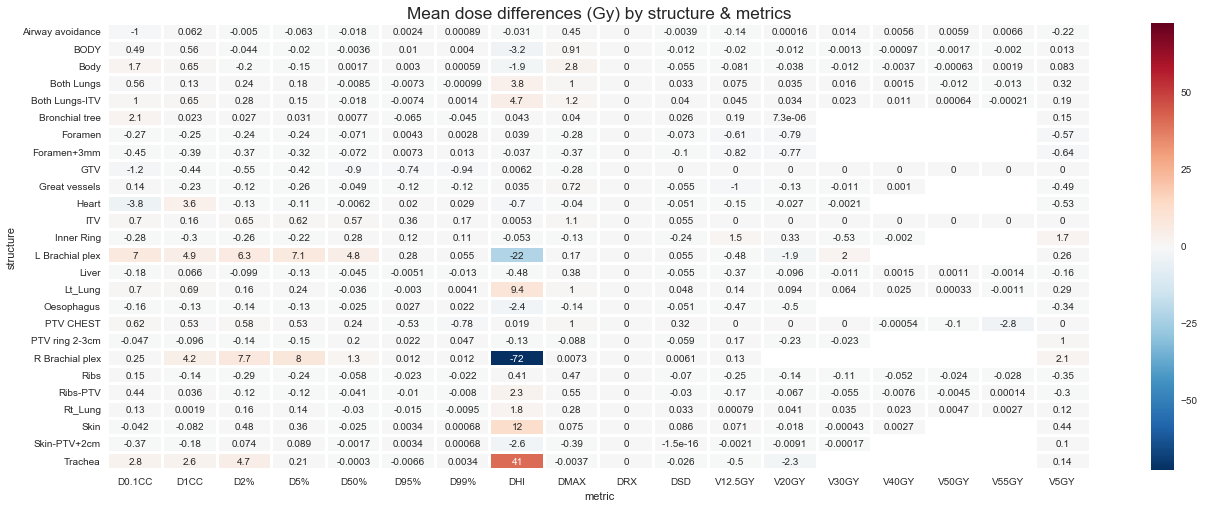

In [350]:
plt.figure(figsize=(22, 8))
ax1 = sns.heatmap(mean_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences (Gy) by structure & metrics', size='xx-large')

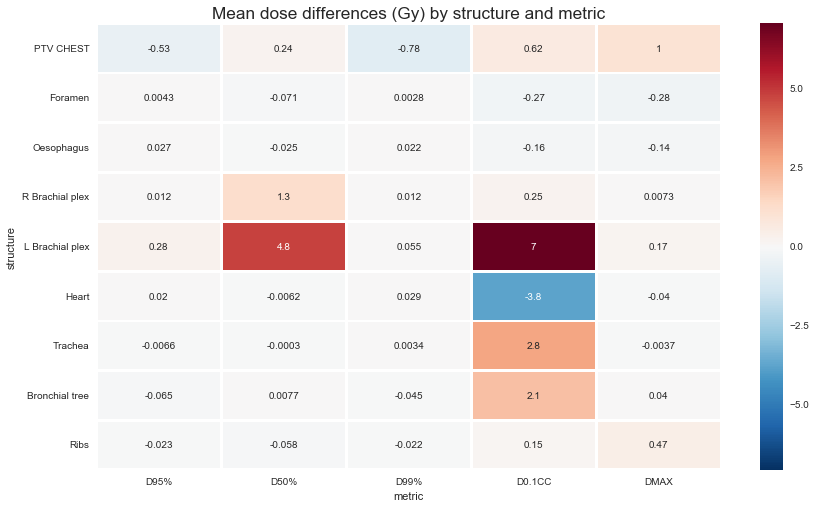

In [455]:
metrics_of_interest = [ 'D95%', 'D50%', 'D99%', 'D0.1CC', 'DMAX']
structures_of_interest = constraints['structure'].unique()

sub_diff_table = mean_diff_table[metrics_of_interest].loc[structures_of_interest]

plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(sub_diff_table, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Mean dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('fig1.png', dpi=300)

## Get wilcoxon p value of differences 

In [181]:
# structures_of_interest = diff_table.index.values
# structures_of_interest

In [182]:
i = len(structures_of_interest)
j = len(metrics_of_interest)
wilcox_data = np.zeros((i,j))  # init an empty array

In [183]:
j = 0
for structure in structures_of_interest:
    i = 0
    for metric in metrics_of_interest:
        A =  d[(d['structure'] == structure) & (d['metric'] == metric)]
        D =  A['diff']
        wilcox_data[j][i] = my_wilcox(D.values)
        i = i + 1
    j = j+ 1  

/Users/robincole/anaconda3/lib/python3.5/site-packages/scipy/stats/morestats.py:2384: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")


Convert to dataframe

In [184]:
wilcox_data_df = pd.DataFrame(data=wilcox_data,    # values
...              index=structures_of_interest,    # 1st column as index
...              columns=metrics_of_interest)  # 1st row as the column names

In [185]:
wilcox_data_df

,D95%,D50%,D99%,D0.1CC,DMAX
PTV CHEST,0.191446,0.155635,0.040888,0.046826,0.005376
Foramen,0.232979,0.003772,0.211476,0.000655,0.000976
Oesophagus,0.002162,0.394246,0.012453,0.008985,0.068476
R Brachial plex,0.099540,0.139756,0.078292,0.649563,0.491119
L Brachial plex,0.064039,0.035465,0.047990,0.509797,0.440867
Heart,0.012453,0.733271,0.001206,0.532130,0.826049
Trachea,0.334277,0.909561,0.139756,0.211476,0.562351
Bronchial tree,0.019878,0.690945,0.030908,0.069144,0.665896
Ribs,0.069144,0.040888,0.023096,0.495521,0.035193
Both Lungs-ITV,0.030908,0.255989,0.139756,0.001785,0.000805


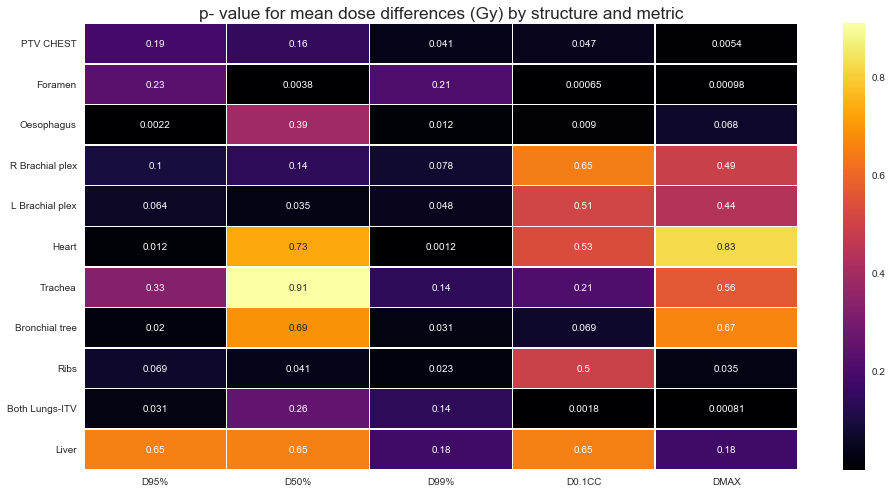

In [194]:
confidence = 1.0
plt.figure(figsize=(16, 8))
ax2 = sns.heatmap(wilcox_data_df[wilcox_data_df<confidence], annot=True, linewidths=.5,  cbar=True, cmap='inferno')
ax2.set_title('p- value for mean dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('fig2.png', dpi=300)

Plot dose differences where statistically significant

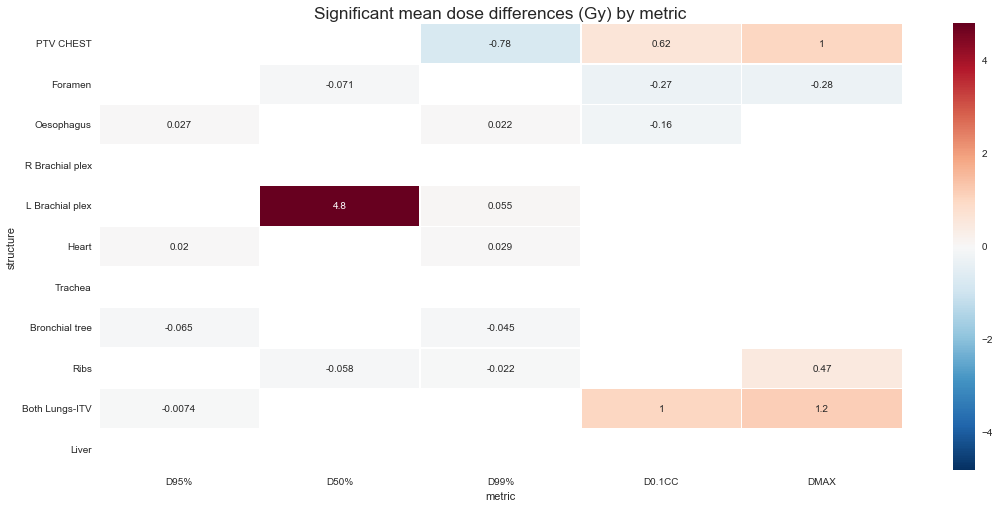

In [207]:
plt.figure(figsize=(18, 8)) 

data = sub_diff_table[wilcox_data_df<0.05]

mask = np.zeros_like(data, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True


ax3 = sns.heatmap(data, annot=True, linewidths=.5, center=0) #  mask=mask,
ax3.set_title('Significant mean dose differences (Gy) by metric', size='xx-large')

# Max dose differences

In [203]:
res_table3 = d.groupby(['structure', 'metric'],as_index=False).max()  # just get mean values 

In [204]:
max_diff_table = res_table3.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
#diff_table.reset_index(level=0, inplace=True)    # must convert the index back into a column
max_diff_table.index
max_diff_table.loc['PTV CHEST']

metric
D0.1CC     1.775331
D1CC       1.957253
D2%        1.943208
D5%        1.943209
D50%       1.697743
D95%       1.278843
D99%       1.124381
DHI        0.099019
DMAX       2.750000
DRX        0.000000
DSD        1.100000
V12.5GY    0.000000
V20GY      0.000000
V30GY      0.000000
V40GY      0.000000
V50GY      0.000009
V55GY      0.211800
V5GY       0.000000
Name: PTV CHEST, dtype: float64

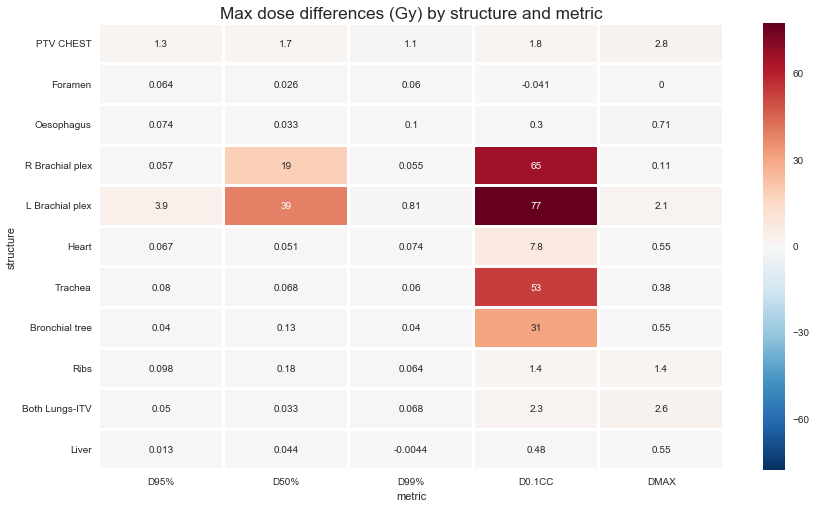

In [206]:
sub_diff_table2 = max_diff_table[metrics_of_interest].loc[structures_of_interest]

plt.figure(figsize=(14, 8))
ax1 = sns.heatmap(sub_diff_table2, annot=True, linewidths=2.0, cbar=True)
ax1.set_title('Max dose differences (Gy) by structure and metric', size='xx-large')
plt.savefig('max_table.png', dpi=300)

Combine constraints with max, mean and signifance of dose differences, and failures

In [296]:
constraints # constraints of interes  

,Structure,Metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?
0,PTV CHEST,D95%,>,100,%,1
1,PTV CHEST,D99%,>,90,%,1
2,PTV CHEST,D0.1CC,between,118-134,%,1
3,Foramen,DMAX,<,25,Gy,0
4,Oesophagus,D0.1CC,<,27,Gy,0
5,R Brachial plex,D0.1CC,<,27,Gy,0
6,L Brachial plex,D0.1CC,<,27,Gy,0
7,Heart,D0.1CC,<,27,Gy,0
8,Trachea,D0.1CC,<,32,Gy,0
9,Bronchial tree,D0.1CC,<,32,Gy,0


In [461]:
constraints_full = constraints.copy()

In [462]:
Mean_diff = mean_diff_table.lookup(constraints['structure'].values, constraints['metric'].values)  # mean diff values from lookup                              
constraints_full['Mean_diff'] = pd.DataFrame(Mean_diff)   # convert to dataframe and apply 

In [463]:
wilcox  =  wilcox_data_df.lookup(constraints['structure'].values, constraints['metric'].values)
constraints_full['wilcox'] = pd.DataFrame(wilcox)

In [464]:
Max_diff = max_diff_table.lookup(constraints['structure'].values, constraints['metric'].values)  
constraints_full['Max_diff'] = pd.DataFrame(Max_diff)

In [465]:
constraints_full

,structure,metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?,Mean_diff,wilcox,Max_diff
0,PTV CHEST,D95%,>,100,%,1,-0.526656,0.191446,1.278843
1,PTV CHEST,D99%,>,90,%,1,-0.780473,0.040888,1.124381
2,PTV CHEST,D0.1CC,between,118-134,%,1,0.619299,0.046826,1.775331
3,Foramen,DMAX,<,25,Gy,0,-0.282333,0.000976,0.000000
4,Oesophagus,D0.1CC,<,27,Gy,0,-0.162007,0.008985,0.297823
5,R Brachial plex,D0.1CC,<,27,Gy,0,0.246638,0.649563,65.476636
6,L Brachial plex,D0.1CC,<,27,Gy,0,7.044839,0.509797,77.466802
7,Heart,D0.1CC,<,27,Gy,0,-3.790933,0.532130,7.799810
8,Trachea,D0.1CC,<,32,Gy,0,2.783140,0.211476,53.401465
9,Bronchial tree,D0.1CC,<,32,Gy,0,2.121001,0.069144,31.208810


In [466]:
test1 = failures[(failures['structure'] == 'PTV CHEST') & ((failures['metric'] == 'D95%'))] # dose constraint violated
test1.size != 0   # True = there is a failure

True

In [467]:
failures

,Case,structure,metric,AAA,Dm,diff
489,Case5,PTV CHEST,D95%,55.648904,54.883221,-0.765683
4287,Case30,PTV CHEST,D95%,56.172306,51.618767,-4.553539
4740,Case31,PTV CHEST,D0.1CC,72.846993,74.024337,1.177344
3966,Case25,Trachea,D0.1CC,15.948424,69.349889,53.401465
3458,Case22,Liver,D50%,1.250632,1.294880,0.044248
4196,Case25,Liver,D50%,6.847959,6.713133,-0.134825
1122,Case12,L Brachial plex,D0.1CC,0.108812,74.346465,74.237653
3912,Case25,L Brachial plex,D0.1CC,0.054618,63.428739,63.374121
4650,Case31,L Brachial plex,D0.1CC,0.109680,77.576481,77.466802
222,Case1,R Brachial plex,D0.1CC,0.324991,65.801627,65.476636


In [470]:
constraints_failed = pd.merge(constraints_full, failures, how='inner', on=['structure', 'metric'])
constraints_failed  # get merged dataframe with failed constraints and details of the failure

,structure,metric,Sign,5_Fraction_55Gy,Unit,Of_Prescription_dose?,Mean_diff,wilcox,Max_diff,Case,AAA,Dm,diff
0,PTV CHEST,D95%,>,100,%,1,-0.526656,0.191446,1.278843,Case5,55.648904,54.883221,-0.765683
1,PTV CHEST,D95%,>,100,%,1,-0.526656,0.191446,1.278843,Case30,56.172306,51.618767,-4.553539
2,PTV CHEST,D0.1CC,between,118-134,%,1,0.619299,0.046826,1.775331,Case31,72.846993,74.024337,1.177344
3,R Brachial plex,D0.1CC,<,27,Gy,0,0.246638,0.649563,65.476636,Case1,0.324991,65.801627,65.476636
4,R Brachial plex,D0.1CC,<,27,Gy,0,0.246638,0.649563,65.476636,Case17,0.435957,48.809596,48.373640
5,L Brachial plex,D0.1CC,<,27,Gy,0,7.044839,0.509797,77.466802,Case12,0.108812,74.346465,74.237653
6,L Brachial plex,D0.1CC,<,27,Gy,0,7.044839,0.509797,77.466802,Case25,0.054618,63.428739,63.374121
7,L Brachial plex,D0.1CC,<,27,Gy,0,7.044839,0.509797,77.466802,Case31,0.109680,77.576481,77.466802
8,Trachea,D0.1CC,<,32,Gy,0,2.783140,0.211476,53.401465,Case25,15.948424,69.349889,53.401465


In [471]:
constraints_failed.to_csv('constraints_failed.csv', index=False) 

# Explore correlations by structure

In [40]:
diff_table = res_table2.pivot(index='structure', columns='metric', values='diff')  # pivot table for diff values
diff_table.reset_index(level=0, inplace=True)  

In [41]:
diff_table = diff_table.transpose()

In [42]:
diff_table

,0,1,2,3,4,5
metric,,,,,,
structure,Foramen,Heart,Lt_Lung,Oesophagus,PTV CHEST,Rt_Lung
D0.1CC,-2.74529,-5.38466,0.674173,-1.87638,1.07563,0.592606
D1CC,-2.7472,2.29645,0.747234,-1.66649,0.837025,0.336425
D2%,-2.70396,-1.07879,0.699098,-1.70086,1.00943,1.07968
D5%,-2.73205,-1.49785,0.919857,-1.59156,0.899626,1.67948
D50%,-5.05869,8.37228,-5.43756,1.25687,0.350911,-5.02763
D95%,12.8548,34.8631,3.69555,28.834,-1.05356,-4.51792
D99%,19.5827,26.4369,2.86929,8.22122,-1.59436,-5.01496
DHI,2.90734,-9.62279,6.84507,-2.49246,9.02438,6.99985


In [43]:
diff_table_correlations = diff_table.corr()
diff_table_correlations

""


In [44]:
plt.figure(figsize=(18, 8))
# ax3 = sns.heatmap(diff_table_correlations , annot=True, linewidths=.5)

# Explore correlations with material data for PTV

In [45]:
PTV_CT = pd.read_csv('PTV_HU_mean_dat.csv')  # import PTV density data

In [46]:
# PTV_CT

Get the PTV differences by metric and case

In [47]:
PTV_metrics = d[d['structure']  == 'PTV CHEST']
PTV_metrics = PTV_metrics.pivot(index='Case',columns='metric', values='diff')   #pivot on case and metric
PTV_metrics.reset_index(level=0, inplace=True)    # must convert the index back into a column

del PTV_metrics['V12.5GY'] # delete as no data for them
del PTV_metrics['V5GY']
# PTV_metrics

In [48]:
PTV_all = pd.merge(PTV_metrics, PTV_CT, how='inner', on=[ 'Case'])  # Merge on case 
PTV_all

metric,Case,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,mean_HU,SD_HU,Volume_PTV
0,Case1,-1.646800,-0.623945,-0.581028,-0.802292,-0.157389,-0.915495,-1.633518,2.850494,-0.381971,-4.000000,-170.699,272.993,72.9
1,Case11,1.044115,0.638813,0.633493,0.642739,0.248408,-2.628825,-3.985440,14.416879,1.655380,13.253012,-551.763,279.318,25.2
2,Case12,2.279966,0.841989,0.910143,0.601526,0.489112,0.196736,-0.240510,3.974143,3.790751,1.282051,-478.357,276.233,38.6
3,Case13,2.109205,1.769138,1.792435,1.538511,1.636643,0.199115,-0.701292,8.237426,1.984733,6.756757,-426.137,296.692,44.7
4,Case14,0.812426,0.124380,0.221460,-0.112804,1.857474,0.445066,-0.370695,-0.878065,1.803752,0.000000,-432.742,277.356,35.4
5,Case16,2.355693,2.143460,2.600956,2.655809,0.429373,-0.788578,-1.580805,12.932591,2.277580,13.829787,-601.037,225.056,8.9
6,Case17,0.776133,1.198678,1.226977,1.144944,0.914957,-0.249615,-0.725107,6.958105,1.416853,2.777778,-275.691,359.180,77.3
7,Case18,2.824736,2.444145,2.870780,2.600269,1.813520,1.118255,1.763484,5.879023,3.427266,8.000000,-559.114,243.114,14.1
8,Case22,-0.101734,0.334918,0.264370,0.389630,0.299438,-0.164480,-0.190877,1.062469,-0.221239,2.352941,-363.164,293.196,35.6
9,Case23,2.312454,2.861348,2.438215,2.914029,1.090400,-0.589348,-1.212738,13.153501,1.972243,16.250000,-650.879,179.334,13.3


In [49]:
# sns.pairplot(PTV_all)

In [50]:
PTV_correlations = PTV_all.corr()
PTV_correlations

metric,D0.1CC,D1CC,D2%,D5%,D50%,D95%,D99%,DHI,DMAX,DSD,mean_HU,SD_HU,Volume_PTV
metric,,,,,,,,,,,,,
D0.1CC,1.000000,0.617233,0.906268,0.796625,0.400423,0.340136,0.359652,0.041674,0.914514,0.167788,-0.307133,-0.165632,-0.265892
D1CC,0.617233,1.000000,0.713018,0.894005,0.724770,0.686345,0.682077,-0.440057,0.454783,-0.164922,0.027899,0.202278,-0.050963
D2%,0.906268,0.713018,1.000000,0.928403,0.399044,0.350939,0.383756,0.061968,0.742861,0.194483,-0.225131,-0.166141,-0.225930
D5%,0.796625,0.894005,0.928403,1.000000,0.501597,0.445250,0.462563,-0.085805,0.586004,0.141344,-0.204784,-0.064768,-0.244744
D50%,0.400423,0.724770,0.399044,0.501597,1.000000,0.952730,0.908601,-0.831142,0.346984,-0.711395,0.550795,0.602303,0.458585
D95%,0.340136,0.686345,0.350939,0.445250,0.952730,1.000000,0.985553,-0.908367,0.318612,-0.800725,0.623298,0.579437,0.504028
D99%,0.359652,0.682077,0.383756,0.462563,0.908601,0.985553,1.000000,-0.885961,0.338290,-0.763182,0.573815,0.502432,0.448762
DHI,0.041674,-0.440057,0.061968,-0.085805,-0.831142,-0.908367,-0.885961,1.000000,0.001690,0.914548,-0.724182,-0.663931,-0.580604
DMAX,0.914514,0.454783,0.742861,0.586004,0.346984,0.318612,0.338290,0.001690,1.000000,0.052740,-0.225475,-0.098497,-0.174584


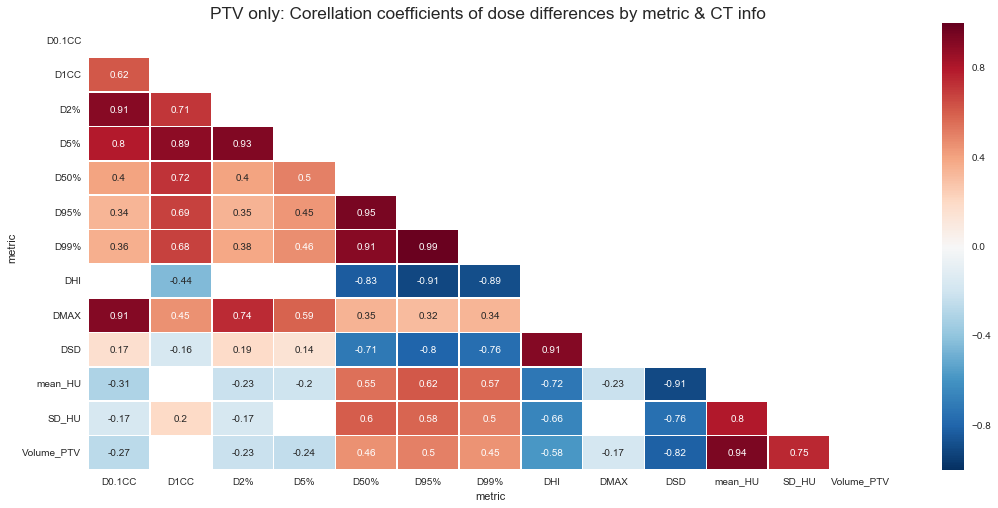

In [51]:
threshold = 0.1  # only show correlation coefficients greater than a threshold value
plt.figure(figsize=(18, 8)) 
mask = np.zeros_like(PTV_correlations, dtype=np.bool)   # create a mask 
mask[np.triu_indices_from(mask)] = True


ax4 = sns.heatmap(PTV_correlations[PTV_correlations.abs() > threshold], annot=True, mask=mask, linewidths=.5, center=0)
ax4.set_title('PTV only: Corellation coefficients of dose differences by metric & CT info ', size='xx-large')

# Investigate corellations 

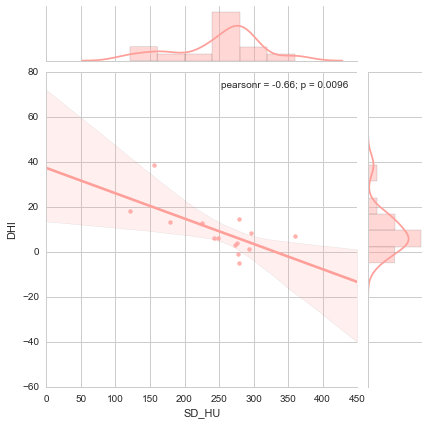

In [143]:
sns.jointplot( "SD_HU","DHI", data=PTV_all, kind="reg", color="r", size=6)
plt.savefig('corrplot1.png', dpi=300)

# Testing

7.55692945586e-10
7.55692945586e-10


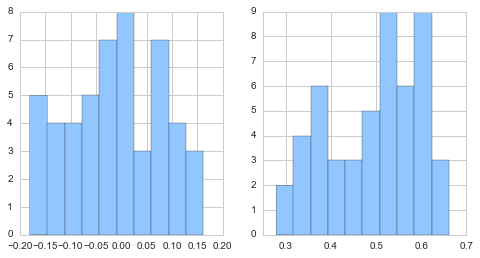

In [32]:
#Test of wilcoxon. See how size of distribution and difference in mean affect result p 

dist_diff = 0.5
samples = 50

mu, sigma = 0, 0.1 
s = np.random.normal(mu, sigma, samples)

mu2, sigma = 0+dist_diff, 0.1 
s2 = np.random.normal(mu2, sigma, samples)

fig = plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(s)

plt.subplot(1, 2, 2)
plt.hist(s2)

z_stat, p_val = wilcoxon(s, s2)   # if only 1 value passed
print(p_val)

z_stat, p_val = wilcoxon(s-s2)   # if only 1 value passed
print(p_val)